<center><h1>Одномерная оптимизация</h1><center>

## План

1. Постановка задачи
2. Численные методы решения
    1. Метод дихтомии (половинного деления)
    2. Метод золотого сечения
    3. Метод Фибоначчи
3. Сравнение результатов и выводы

In [1]:
# необходимые библиотеки и настройки
%matplotlib notebook
import numpy as np
from numpy import array
from functools import reduce
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, OptimizeResult
plt.style.use("seaborn")
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

$\newcommand{\indent}{\hspace{0.75cm}}$

## Постановка задачи

Задача заключается в том, чтобы найти минимум некоторой функции $f(x)$ заданной на промежутке $\left[a;b\right]\subset \mathbb{R}$, считая, что она унимодальна (минимум строго один). Формальная запись задачи: $$ f(x) \to \min_{x\in \left[a;b\right]},$$ или же $$f^{*}=\min_{x\in \left[a;b\right]} f(x),\text{ }x^{*} = \arg\min_{x\in \left[a;b\right]}f(x).$$
Если нас интересует максимум функции на отрезке, мы можем попросту перейти к задаче минимизации функции $g(x)\equiv -f(x)$.

>Классическим примером может служить задача максимизации прибыли $\pi$ по объёму выпуска $Q$ из теоретической микроэкономики. На объём выпуска накладываются два естественных ограничения: снизу нулём и сверху неким числом $Q_0$, описывающим тот максимум, что мы в принципе можем производить. Запишется задача тогда так: $$ \pi(Q)\to\max_{Q\in[0; Q_0]}.$$ 
Именно численные методы решения могут нас, к примеру, в тех случаях, когда функция прибыли получилась очень сложной, или приравнивание производной к 0 просто приводит к неразрешимому уравению.

Решать задачу мы будем тремя методами, названия которых упомянуты выше, а иллюстрировать их использование мы будем на примере задачи минимизации функции $f(x)\equiv -x^5 - 10x^2 + 10x-2$ на отрезке $\left[-2;-1\right]$. Построим её график:

<IPython.core.display.Javascript object>


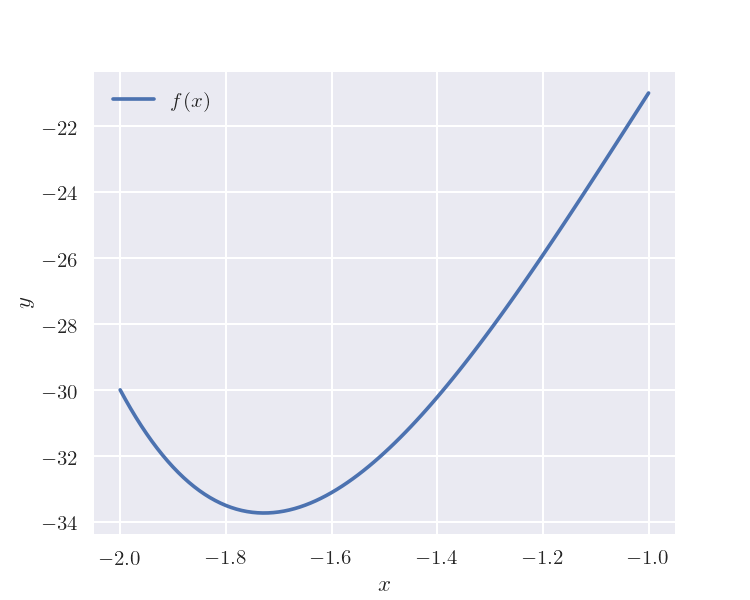

In [19]:
f = lambda x: -x**5 - 10*x**2 + 10*x - 2
a, b = -2, -1
eps = 0.001

X = np.linspace(a, b, 101)
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(X, f(X), label='$f(x)$')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend();

In [3]:
def plot_solution(f, X, x_hist, f_hist):
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    ax.plot(X, f(X), label='$f(x)$', alpha=0.6)
    x_opt, f_opt = x_hist[-1], f_hist[-1]
    ax.scatter(x_hist[:-1], f_hist[:-1], s=10, c='r', label='Minimizing sequence')
    ax.scatter(x_opt, f_opt, s=30, c='r', 
               label='$(x^{*}, f^{*})=(%.4f, %.4f)$' % (x_opt, f_opt))
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.legend();
    return fig

## Численные методы решения

$\indent$Мы знаем, что минимум точно находится между границами $a$ и $b$ отрезка. Все рассмотренные ниже методы решения имеют общую идею: постепенно сужать область поиска, каким-то образом строя последовательность отрезков $[a_k; b_k]$, каждый из которых имеет меньшую длину, чем предыдущий, и заведомо содержит в себе точку минимума $x^{*}$. Различаются методы, как можно догадаться, в способе перехода от отрезка $[a_k; b_k]$ к отрезку $[a_{k+1}; b_{k+1}]$.

$\indent$В определённый момент, когда длина очередного отрезка окажется меньше заданной нами точности $\varepsilon$, мы остановимся, и в качестве приближённого решения задачи просто возьмём середину отрезка $\dfrac{a_k + b_k}{2}$.

$\indent$Для программной реализации воспользуемся интерфейсом функции `minimize_scalar` пакета `scipy.optimize`, которая принимает на вход функцию вида $f: \mathbb{R}\to\mathbb{R}$, метод для оптимизации и необходимые параметры, а возвращает обьект класса `OptimizeResult`, который просто хранит в себе всю нужную информацию о решении. В нашем случае, он будет хранить само решение задачи — числа $x^{*}$ и $f^{*} = f(x^{*})$, — 

### A. Метод дихтомии 

_Описание_

_Первая итерация_

In [4]:
def dichtomy(func, bounds, tol, args=(), **options):
    a, b = [bounds[0]], [bounds[1]]
    k = 0
    while np.abs(a[k] - b[k]) >= tol:
        xk = (b[k] + a[k])/2
        x1, x2 = xk - tol/2, xk + tol/2
        f1, f2 = f(x1), f(x2)
        if f1 < f2:
            a.append(a[k])
            b.append(xk)
        else:
            a.append(xk)
            b.append(b[k])
        k += 1
    
    x_hist = (array(a) + array(b))/2
    
    return OptimizeResult(
        x=x_hist[-1], fun=f(x_hist[-1]), n_iter=k,
        x_hist=x_hist, f_hist=f(x_hist))

<IPython.core.display.Javascript object>


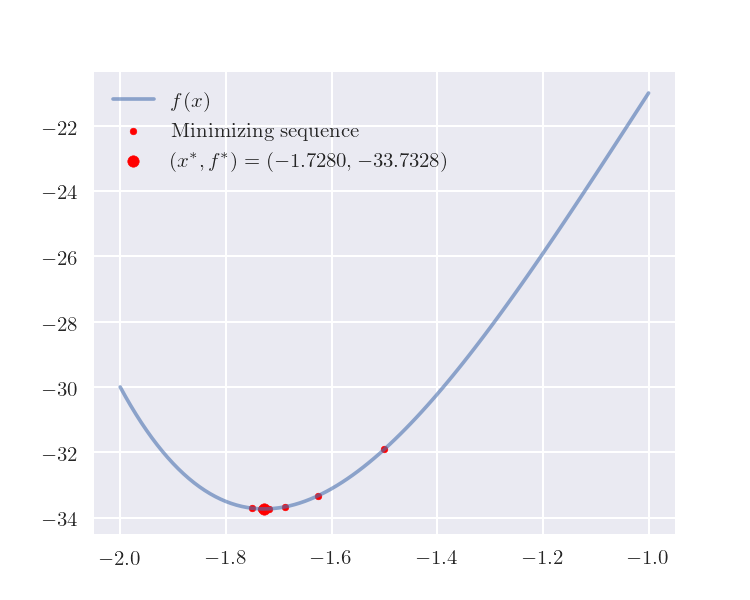

In [5]:
res_dicht = minimize_scalar(
    f, # функция, которую минимизируем
    bounds=(a, b), # область
    method=dichtomy, # используемый метод
    tol=eps # точность
)

print('Minimizing sequence: ')
print(res_dicht.x_hist)

fig_dicht = plot_solution(f, X, res_dicht.x_hist, res_dicht.f_hist)

### B. Метод золотого сечения 

_Описание_

_Первая итерация_

In [6]:
def golden_ratio(func, bounds, tol, args=(), **options):
    tau = (1 + np.sqrt(5))/2
    a, b = [bounds[0]], [bounds[1]]
    x1 = a[0] + (b[0]-a[0])/tau**2
    x2 = a[0] + (b[0]-a[0])/tau
    k = 0
    while np.abs(a[k] - b[k]) >= tol:
        f1, f2 = func(x1), func(x2)
        if f1 < f2:
            a.append(a[k])
            b.append(x2)
            x2 = x1
            x1 = a[k+1] + (b[k+1] - a[k+1])/tau**2 
        else:
            a.append(x1)
            b.append(b[k])
            x1 = x2
            x2 = a[k+1] + (b[k+1] - a[k+1])/tau
        k += 1
    x_hist = (array(a) + array(b))/2
    return OptimizeResult(
        x=x_hist[-1], fun=f(x_hist[-1]), n_iter=k,
        x_hist=x_hist, f_hist=f(x_hist))

Minimizing sequence: 
[-1.5        -1.69098301 -1.80901699 -1.73606798 -1.69098301 -1.71884705
 -1.73606798 -1.72542486 -1.73200267 -1.72793736 -1.72542486 -1.72697767
 -1.72793736 -1.72734424 -1.72771081 -1.72793736]


<IPython.core.display.Javascript object>


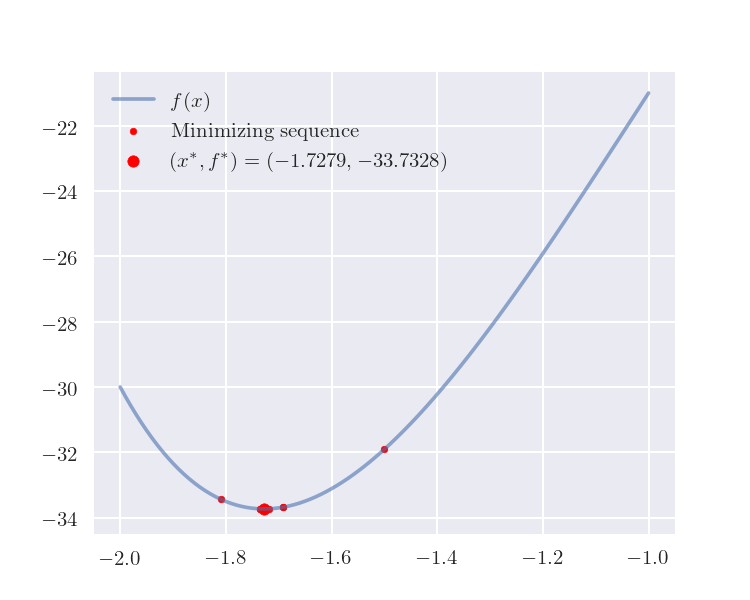

In [17]:
res_gr = minimize_scalar(
    f, # function to minimize
    bounds=(a, b), # domain
    method=golden_ratio, # method to use
    tol=0.001 # with tolerance
)

print('Minimizing sequence: ')
print(res_gr.x_hist)

fig_gr = plot_solution(f, X, res_gr.x_hist, res_gr.f_hist)

### C. Метод Фибоначчи 

_Описание_

In [11]:
def get_limited_fibonacci_sequence(value):
    fib = [0, 1]
    add_next = lambda l: l.append(l[-2]+l[-1])
    while fib[-1] < value:
        add_next(fib)
    return fib


fib = get_limited_fibonacci_sequence((b-a)/eps)
print("First %d values of Fibonacci sequence:" % len(fib))
print(", ".join(map(str, fib)))

First 18 values of Fibonacci sequence:
0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597


_Первая итерация_

In [12]:
def fibonacci(func, bounds, tol, args=(), **options):
    a, b = [bounds[0]], [bounds[1]]
    fib = get_limited_fibonacci_sequence((b[0]-a[0])/tol)
    N = len(fib) - 1
    k = 0
    while np.abs(a[k] - b[k]) >= tol:
        x1 = a[k] + (b[k]-a[k])*fib[N-k-2]/fib[N-k] - (-1)**(N-k)/fib[N-k]*tol
        x2 = a[k] + (b[k]-a[k])*fib[N-k-1]/fib[N-k] + (-1)**(N-k)/fib[N-k]*tol
        f1, f2 = func(x1), func(x2)
        if f1 < f2:
            a.append(a[k])
            b.append(x2)
            x2 = x1
            x1 = a[k+1] + (b[k+1]-a[k+1])*fib[N-k-3]/fib[N-k-1] - (-1)**(N-k-1)/fib[N-k-1]*tol
        else:
            a.append(x1)
            b.append(b[k])
            x1 = x2
            x2 = a[k+1] + (b[k+1]-a[k+1])*fib[N-k-2]/fib[N-k-1] + (-1)**(N-k-1)/fib[N-k-1]*tol
        k += 1
    x_hist = (array(a) + array(b))/2
    return OptimizeResult(
        x=x_hist[-1], fun=f(x_hist[-1]), n_iter=k,
        x_hist=x_hist, f_hist=f(x_hist))

Minimizing sequence: 
[-1.5        -1.69098341 -1.80901659 -1.73606637 -1.69098341 -1.71885066
 -1.73606637 -1.72541484 -1.73197902 -1.72789167 -1.72541484 -1.72702536
 -1.72789167 -1.72714746 -1.72726957 -1.72664746]


<IPython.core.display.Javascript object>


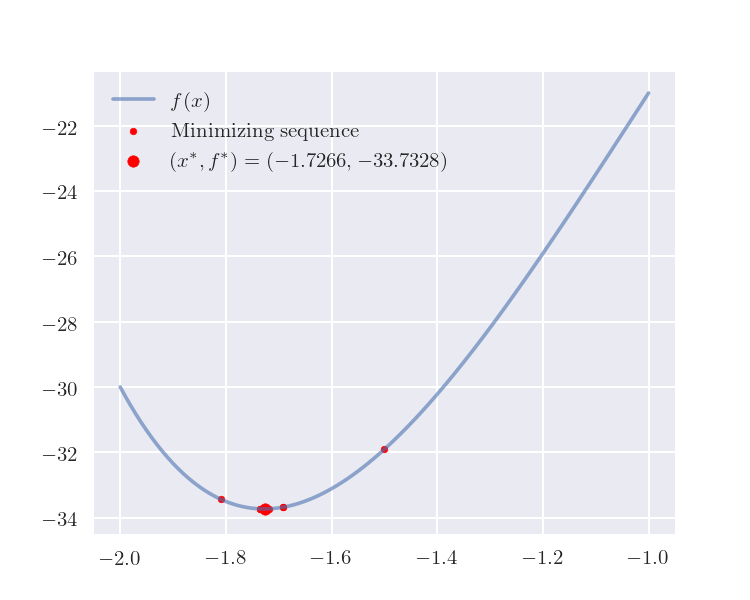

In [16]:
res_fib = minimize_scalar(
    f, # function to minimize
    bounds=(a, b), # domain
    method=fibonacci, # method to use
    tol=0.001 # with tolerance (epsilon)
)

print('Minimizing sequence: ')
print(res_fib.x_hist)

fig_fib = plot_solution(f, X, res_fib.x_hist, res_fib.f_hist)

## Сравнение результатов и выводы 

In [20]:
res_dicht.n_iter, res_gr.n_iter, res_fib.n_iter

(10, 15, 15)